## 1. BN应该放在全连接核卷积的输出上，激活函数前
## 2. 对全连接层作用在特征维
## 3. 对卷积层作用在通道维
## 4. 它可能是通过在每个小批量里加入噪音来控制模型的复杂度，因此没必要和Dropout混合使用
## 5. 可以加速模型收敛，但一般不改变模型精度

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
# moving_mean, moving_var是在做推理时用的
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():  # 做推理
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # X的维度为2，则为全连接层（batch_size, 特征）
        # X的维度为4，则为卷积层（batch_size, channel, H, W）
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)  # 计算每一个特征的均值
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # 只保留通道维
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))  # 用于声明是网络中需要学习的参数
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [11]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.273, train acc 0.899, test acc 0.813
74412.0 examples/sec on cuda:0


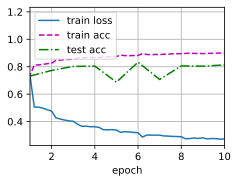

In [12]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
net[1].beta.data.flatten(), net[1].gamma.data.flatten()

(tensor([-3.0920,  1.2323, -2.2725,  1.5163, -2.0012,  2.1823], device='cuda:0'),
 tensor([3.1179, 2.5862, 4.4359, 0.9695, 3.2395, 2.4871], device='cuda:0'))

## 简明实现

In [22]:
# BatchNorm2d用在图像数据
# BatchNorm1d用在全连接层
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.269, train acc 0.901, test acc 0.873
134705.4 examples/sec on cuda:0


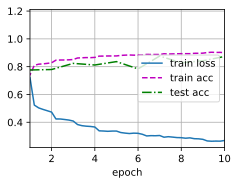

In [23]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())